# DistilBERT classifier for argument relations

This DistilBERT implementation follows [Raschka et al. (2022)](https://github.com/rasbt/machine-learning-book)
from pp. 575-586. Here is the corresponding: [code](https://github.com/rasbt/machine-learning-book/blob/main/ch16/ch16-part3-bert.ipynb).

Sebastian Raschka,  Yuxi Liu and Vahid Mirjalili.  2022. Machine Learning with PyTorch and Scikit-Learn: Develop machine learning and deep learning models with Python. Packt Publishing.

## Settings and imports

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

import os
import sys
PATH = r"/content/gdrive/My Drive/Colab Notebooks/AM_BERT_classification"
os.chdir(PATH)

# Create directory, if it does not exist
os.makedirs("models", exist_ok=True)

# Add the subdirectory to the sys.path
subdirectory_path = os.path.join(os.getcwd(), "scripts")
sys.path.insert(0, subdirectory_path)

Mounted at /content/gdrive


In [ ]:
from corpus_loader import CorpusLoader
from cdcp_preprocessor import CDCPRelationPrepper

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample

import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR

from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification

Specifying general settings to make the results reproducible.

In [ ]:
torch.backends.cudnn.deterministic = True
random_seed = 80
torch.manual_seed(random_seed)

available_gpu = torch.cuda.is_available()

if available_gpu:
  print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
  print("GPU not available.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data

**CDCP**: Loading relations from the [Cornell eRulemaking Corpus – CDCP](https://facultystaff.richmond.edu/~jpark/papers/jpark_lrec18.pdf) with custom classes (CorpusLoader, CDCPRelationPrepper). The arguments were annotated with two types of *support* relations: `reason` and `evidence`. As the goal of the training here is a less fine-grained classification task, the two support types are grouped together as only `support`. In the preprocessing script, depending on the parameters (direction, window clipping), `None` relations  are also added as 0.

**Reference**

Joonsuk Park and Claire Cardie. 2018. A Corpus of eRulemaking User Comments
for Measuring Evaluability of Arguments. In Proceedings of the Eleventh
International Conference on Language Resources and Evaluation (LREC 2018),
Miyazaki, Japan. European Language Resources Association (ELRA).

The **corpus statistics** as of 11.07.2024 is as follows:

| Relation statistics                | Count |
|------------------------------------|-------|
| Support relations in training set  | 1103  |
| Support relations in test set      | 324   |
| Support relations in sum           | 1427  |

Please note that the number of support relations differs from the original publication. A total of 1427 support relations can be counted with the preprocessing script in `scripts/cdcp_preprocessor.py`, whereas the original publication reported 1220 [(Park & Cardie 2018, p. 1627)](https://facultystaff.richmond.edu/~jpark/papers/jpark_lrec18.pdf). However, a [separate corpus statistics](https://huggingface.co/datasets/DFKI-SLT/cdcp/blob/main/README.md) of the CDCP from the DFKI HuggingFace group reported 1426 relations, which is very close to the result provided here.

Below a few variables, designating whether the data should include only pairs of labeled relations where the order indicates the direction of the relation as well as whether window clipping should be applied, filtering potential relations between ADUs that are not within the clipping windows distance. Without a window, all possible relation pairs sampled without replacement are calculated: For example, a set of 4 elements has 4!/(4-2)! = 12 relations.

In [ ]:
corpus_loader = CorpusLoader()
relations = CDCPRelationPrepper()
directed = True  # Consider order of relation pairs
window = True  # If True only pairs within a window are considered
window_size = 3  # Size of window to the left and right

# The URL for the CDPC as zip file.
url_cdcp = "https://facultystaff.richmond.edu/~jpark/data/cdcp_acl17.zip"
cdcp_save_path = "data/corpus_1/"
cdcp_path_train = "data/corpus_1/cdcp/train/"
cdcp_path_test = "data/corpus_1/cdcp/test/"
cdcp_file_type_ann = ".ann.json"
cdcp_file_type_text = ".txt"

Loading the data:

In [ ]:
# If data/corpus_1/ exists, download will be skipped.
corpus_loader.download_file_from(url_cdcp, cdcp_save_path)

#### Training set ####

training_annotation = corpus_loader.load_files_from(cdcp_path_train,
                                                    cdcp_file_type_ann)
training_text = corpus_loader.load_files_from(cdcp_path_train,
                                              cdcp_file_type_text)

training_set = relations.pair_extraction(training_annotation,
                                         training_text,
                                         directed,
                                         window,
                                         window_size)
print(training_set.head())
print(training_set.shape)

#### Test set ####

test_annotation = corpus_loader.load_files_from(cdcp_path_test,
                                                cdcp_file_type_ann)
test_text = corpus_loader.load_files_from(cdcp_path_test,
                                          cdcp_file_type_text)

test_set = relations.pair_extraction(test_annotation,
                                     test_text,
                                     directed,
                                     window,  # Manual change of window for test
                                     window_size)
print(test_set.head())
print(test_set.shape)

Path data/corpus_1/ already exists. Skipping download.
  label                                              pairs
0  None  (State and local court rules sometimes make de...
1   sup  (State and local court rules sometimes make de...
2   sup  ( For example, when a person who allegedly owe...
3  None  ( For example, when a person who allegedly owe...
4  None  ( I urge the CFPB to find practices that invol...
(16602, 2)
  label                                              pairs
0  None  (Recently, courts have held that debt collecto...
1  None  (Recently, courts have held that debt collecto...
2  None  ( As the NAF studies reflect, arbitration has ...
3   sup  ( As the NAF studies reflect, arbitration has ...
4  None  ( I urge the CFPB to include in a rule languag...
(4398, 2)


Applying numeric labels to training and test set. In the undirected case, we want to test whether a relation between two ADUs holds, regardless of its type and direction, making this a binary classification task. Since the CDCP corpus only provides us with one kind of relation, the undirected and directed scenarios only differ in terms of their direction.

**Undirected?**:
>ADU1 -rel/sup- ADU2

**Directed?**:
>ADU1 -sup-> ADU2

In [ ]:
label_mapping = {
    "None": 0,
    "sup": 1
}

training_set["label"] = training_set["label"].map(label_mapping)
test_set["label"] = test_set["label"].map(label_mapping)
print(training_set.head())

   label                                              pairs
0      0  (State and local court rules sometimes make de...
1      1  (State and local court rules sometimes make de...
2      1  ( For example, when a person who allegedly owe...
3      0  ( For example, when a person who allegedly owe...
4      0  ( I urge the CFPB to find practices that invol...


Note, without small windows delineating the amout of relevant `support` relations, the training and test set are larger than the component instance sets because for each document all possible ordered pairs for relations sampled without replacement are calculated: For example, a set of 4 elements has 4!/(4-2)! = 12 relations`

In [ ]:
support_relations_training = training_set[training_set["label"] == 1]
support_relations_test = test_set[test_set["label"] == 1]

print(len(support_relations_training))
print(len(support_relations_test))

share_training = len(support_relations_training) / len(training_set)
share_test = len(support_relations_test) / len(test_set)

print(share_training)
print(share_test)

1033
280
0.06222141910613179
0.06366530241018645


Without window clipping only about 3% of the data are positive instances in the directed graph scenario, and about 6% in the undirected. For this reason, it makes sense to downsample the majority class of the training set. This will also improve the training time because the model will have to process less examples.

In [ ]:
# Format needs to be changed to DataFrame for applying .applymap() in later
# processing
X_train = pd.DataFrame(training_set["pairs"])
y_train = training_set["label"]
X_test = pd.DataFrame(test_set["pairs"])
y_test = test_set["label"]

if not window or window_size >=3:
    df = pd.DataFrame({"pairs": training_set["pairs"],
                       "label": training_set["label"]})

    minority_class = df["label"].value_counts().idxmin()
    majority_class = df["label"].value_counts().idxmax()

    df_minority = df[df["label"] == minority_class]
    df_majority = df[df["label"] == majority_class]

    # Downsample the majority class by a factor of 10
    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=len(df_minority) * 10,
        random_state=random_seed
    )

    # Combine the downsampled majority class with the minority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])

    df_downsampled = df_downsampled.sample(frac=1,
                                           random_state=random_seed).reset_index(drop=True)

    # Separate X_downsampled and y_downsampled
    X_downsampled = df_downsampled["pairs"]
    y_downsampled = df_downsampled["label"]

    X_train = pd.DataFrame(X_downsampled)
    y_train = pd.Series(y_downsampled)

    print(X_downsampled.shape)
    print(y_downsampled.shape)

    share_training = len(support_relations_training) / len(X_downsampled)
    share_test = len(support_relations_test) / len(test_set)

    print(share_training)
    print(share_test)

(11363,)
(11363,)
0.09090909090909091
0.06366530241018645


Splitting the training set into training and validation sets and stratifying the labels. Stratification only works with shuffling. The CDCP corpus comes with a training and test split where 80% of all instances belong to the training set and 20% to the test set. To create a validation set, which corresponds to 10% of the overall data, we can further split the training set into two halves where the validation set consists of 12,5% of the samples (taken from the 80% training split, this results in 10% of the overall data). In this fashion, we get a 70:10:20 split.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size=0.125,
                                                      stratify=y_train,
                                                      random_state=random_seed)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

print(X_train[0:2])
print(y_train[0:2])


(9942, 1)
(1421, 1)
(4398, 1)
                                                  pairs
474   ( They should not be allowed to offer advice o...
1245  ( Reading your "if there is a new federal rule...
474     0
1245    0
Name: label, dtype: int64


## Data preparation

As the data for the ADU pairs is still stored as tuples, we need to split them in half so that the tokenizer can create a schema that resembles the following structure

> [CLS] Proposition 1 [SEP] Proposition 2 [Sep] [PAD] [PAD] ...

Where [CLS] and [SEP] are special tokens used for telling the BERT model where propositions start and end. [PAD] is used for padding so that each sample is of equal size.

In [ ]:
# Separate dataframes with tuples into two separate frames
X_train_prop_a = X_train.applymap(lambda x: x[0])
X_train_prop_b = X_train.applymap(lambda x: x[1])
X_valid_prop_a = X_valid.applymap(lambda x: x[0])
X_valid_prop_b = X_valid.applymap(lambda x: x[1])
X_test_prop_a = X_test.applymap(lambda x: x[0])
X_test_prop_b = X_test.applymap(lambda x: x[1])

# Accessing values from the frames
X_train_prop_a = X_train_prop_a.values.flatten().tolist()
X_train_prop_b = X_train_prop_b.values.flatten().tolist()
X_valid_prop_a = X_valid_prop_a.values.flatten().tolist()
X_valid_prop_b = X_valid_prop_b.values.flatten().tolist()
X_test_prop_a = X_test_prop_a.values.flatten().tolist()
X_test_prop_b = X_test_prop_b.values.flatten().tolist()

y_train = y_train.values
y_valid = y_valid.values
y_test = y_test.values

print(X_train_prop_a[0:3])
print(X_train_prop_b[0:3])

[' They should not be allowed to offer advice on what bills to pay and how to pay them.', ' Reading your "if there is a new federal rule regarding messages..." It seems like this agency is trying very hard to make it easy to get around the court decision which is one of the few that protected consumers,', ' This is letting someone else know of a debt who should not be privy to that information.']
[' Perhaps the CFPB should allow collectors to offer referrals on financial advice,', 'This is unreal.', " Yet, there is a discussion to allow these calls at a consumer's work?"]




Tokenizing the dataset with the tokenizer taken from the pre-trained model. The advantage of using the inherited tokenizer is that "the consistency between the pre-trained model and the dataset" is maintained (Raschka 2022, p. 577)


In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
    )

train_encodings = tokenizer(X_train_prop_a,
                            X_train_prop_b,
                            truncation=True,
                            padding=True)
valid_encodings = tokenizer(list(X_valid_prop_a),
                            list(X_valid_prop_b),
                            truncation=True,
                            padding=True)
test_encodings = tokenizer(list(X_test_prop_a),
                           list(X_test_prop_b),
                           truncation=True,
                           padding=True)

print(len(train_encodings["input_ids"]))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

9942


Let's visualize the tokenized instances with corresponding ids and masks.

In [ ]:
for i in range(3):
    print(f"input_ids: {train_encodings['input_ids'][i]}")
    print(f"attention_mask: {train_encodings['attention_mask'][i]}")
    print(f"sentence: {tokenizer.decode(train_encodings['input_ids'][i])}")

input_ids: [101, 2027, 2323, 2025, 2022, 3039, 2000, 3749, 6040, 2006, 2054, 8236, 2000, 3477, 1998, 2129, 2000, 3477, 2068, 1012, 102, 3383, 1996, 12935, 2361, 2497, 2323, 3499, 14256, 2000, 3749, 6523, 7941, 2015, 2006, 3361, 6040, 1010, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

A self-defined data class helps with customizing all related features and functions.

In [ ]:
class CDCPDataset(torch.utils.data.Dataset):
    """
    Self-defined data class to customize features by changing some magic
    methods. __getitem__ only extraxts the most relevant information from the
    encodings.
    """

    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx])
                for key, val in self.encodings.items()}
        item["label"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

Creating PyTorch Dataloaders:

The data was already shuffled with the splits to stratisfy the classes for the test and validation sets. This was also necessary because Scikit learn's resample method works with shuffling.

Shuffling the data stabilizes the training process and can potentially enhance the model's final performance.

In [ ]:
train_dataset = CDCPDataset(train_encodings, y_train)
valid_dataset = CDCPDataset(valid_encodings, y_valid)
test_dataset = CDCPDataset(test_encodings, y_test)

batch_size = 128  # Slight boost for T4 GPU if batch size is 128

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size, shuffle=True
)

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))


9942
1421
4398


## Fine-tuning the model

### [DistilBERT model](https://huggingface.co/distilbert/distilbert-base-uncased):

The DistilBERT base uncased model is used as it is faster, lighter, and smaller than BERT [(Sanh et al. 2019)](https://arxiv.org/abs/1910.01108), but reaches performance results close to BERT. ***DistilBertForSequenceClassification*** is designed for sequence classification tasks. It includes a classification head on top of the pooled output, specifically for tasks like sentiment analysis, spam detection, etc. When we instantiate the model, the loss function used is `CrossEntropyLoss`. Passing the labels along with the input to the model is sufficient, the Hugging Face library automatically computes the loss if the labels are provided.

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased"
)
model_name = f"models/DistilBert_relation_cdcp_class_dir_window3_1_3.pt"
model.to(device)
model.train()

optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = LinearLR(optimizer,
                     start_factor=1.0,
                     end_factor=0.3,
                     total_iters=10)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy function to evaluate the model:

In [ ]:
def compute_accuracy(model, data_loader, device):
    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for batch_idx, batch in enumerate(data_loader):

            # Prepare data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs["logits"]
            predicted_labels = torch.argmax(logits, dim=1)
            num_examples += labels.size(0)
            correct_pred += (predicted_labels == labels).sum()

        return correct_pred.float()/num_examples * 100

F1 function to evaluate the model:

In [ ]:
def compute_f1_scores(model, data_loader, device):
    with torch.no_grad():

        all_labels = []
        all_predictions = []

        for batch_idx, batch in enumerate(data_loader):

            # Prepare data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs["logits"]
            predicted_labels = torch.argmax(logits, dim=1)

            # If the tensors are on the GPU, .cpu() moves them to the CPU.
            # This step is necessary because the numpy() method is not supported
            # on GPU tensors.
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted_labels.cpu().numpy())

        # Create a report dictionary
        report = classification_report(all_labels,
                                       all_predictions,
                                       output_dict=True)


        return report

Function to evaluate loss:

In [ ]:
def compute_loss(model, data_loader, device):
    # Dropout is disabled and batch normalization uses the learned statistics
    # instead of the statistics of the current batch.
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):

            # Prepare data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = model(input_ids,
                            attention_mask=attention_mask,
                            labels=labels)
            loss, logits = outputs["loss"], outputs["logits"]

            running_loss += loss.item()

    final_loss = running_loss/ len(data_loader)

    return final_loss

### Training:

This is the training loop for finetuning the model. After some manual tests with DistilBERT, five epochs are sufficient for the model to converge for the given task.

In [ ]:
start_time = time.time()
num_epochs = 5

train_acc_history = [0] * num_epochs
valid_acc_history = [0] * num_epochs

train_loss_history = [0] * num_epochs
valid_loss_history = [0] * num_epochs

for epoch in range(num_epochs):

    model.train()
    running_train_loss = 0.0

    for batch_idx, batch in enumerate(train_loader):

        # Prepare data
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = model(input_ids,
                        attention_mask=attention_mask,
                        labels=labels)
        loss, logits = outputs["loss"], outputs["logits"]

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Scheduler step (with warmup?)
        scheduler.step()

        # Logging
        if not batch_idx % 10:
            print(f"Epoch: {epoch+1:04d}/{num_epochs:04d}"
                  f" | Batch "
                  f"{batch_idx:04d}/"
                  f"{len(train_loader):04d} | "
                  f"Loss: {loss:.4f}")

    train_loss = running_train_loss / len(train_loader)
    valid_loss = compute_loss(model, valid_loader, device)

    train_loss_history[epoch] = train_loss
    valid_loss_history[epoch] = valid_loss

    print(f"Epoch: {epoch+1}/{num_epochs} | "
          f"Training Loss: {train_loss:.4f} | "
          f"Validation Loss: {valid_loss:.4f}")

    with torch.set_grad_enabled(False):
        train_acc = compute_accuracy(model, train_loader, device)
        valid_acc = compute_accuracy(model, valid_loader, device)
        print(f"Training accuracy: "
              f"{train_acc:.2f}%"
              f"\nValidation accuracy: "
              f"{valid_acc:.2f}%"
              )

    train_acc_history[epoch] = train_acc
    valid_acc_history[epoch] = valid_acc

# Evaluate and save model
model.eval()
torch.save(model.state_dict(), model_name)

print(f"Time elapsed: {(time.time() - start_time)/60:.2f} min")

Epoch: 0001/0005 | Batch 0000/0078 | Loss: 0.7542
Epoch: 0001/0005 | Batch 0010/0078 | Loss: 0.3495
Epoch: 0001/0005 | Batch 0020/0078 | Loss: 0.1759
Epoch: 0001/0005 | Batch 0030/0078 | Loss: 0.2118
Epoch: 0001/0005 | Batch 0040/0078 | Loss: 0.2263
Epoch: 0001/0005 | Batch 0050/0078 | Loss: 0.3472
Epoch: 0001/0005 | Batch 0060/0078 | Loss: 0.2875
Epoch: 0001/0005 | Batch 0070/0078 | Loss: 0.2651
Epoch: 1/5 | Training Loss: 0.3208 | Validation Loss: 0.2838
Training accuracy: 90.91%
Validation accuracy: 90.92%
Epoch: 0002/0005 | Batch 0000/0078 | Loss: 0.3110
Epoch: 0002/0005 | Batch 0010/0078 | Loss: 0.2509
Epoch: 0002/0005 | Batch 0020/0078 | Loss: 0.3640
Epoch: 0002/0005 | Batch 0030/0078 | Loss: 0.2769
Epoch: 0002/0005 | Batch 0040/0078 | Loss: 0.2289
Epoch: 0002/0005 | Batch 0050/0078 | Loss: 0.3443
Epoch: 0002/0005 | Batch 0060/0078 | Loss: 0.1922
Epoch: 0002/0005 | Batch 0070/0078 | Loss: 0.3980
Epoch: 2/5 | Training Loss: 0.2903 | Validation Loss: 0.2874
Training accuracy: 90.91

## Evaluation

Visualizing training accuracy with Matplotlib:

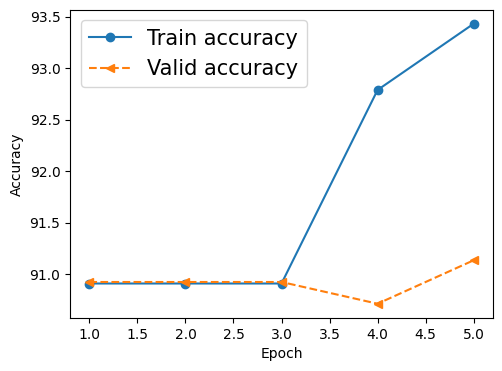

In [ ]:
x_arr = np.arange(len(train_acc_history)) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, [e.cpu() for e in train_acc_history],
        "-o",
        label="Train accuracy")
ax.plot(x_arr, [e.cpu() for e in valid_acc_history],
        "--<",
        label="Valid accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend(fontsize=15)

Visualizing loss during training with Matplotlib:


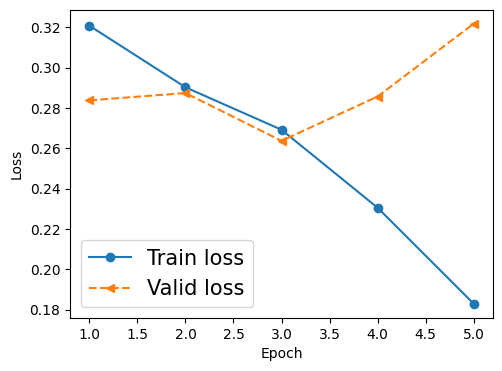

In [ ]:
x_arr = np.arange(len(train_loss_history)) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, train_loss_history, "-o", label="Train loss")
ax.plot(x_arr, valid_loss_history, "--<", label="Valid loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(fontsize=15)

# Metrics:

To report a full range of metrics, we can use the customized `compute_f1_scores`. The function returns `precision`, `recall`, `accuracy`, `macro F1` and `weighted F1` scores. For an imbalanced distribution of classes, it is reasonable to consider the weighted F1 score because it takes the support count for each class into account.

Macro F1 := Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

Micro F1 / weighted average := Calculate metrics globally by counting the total true positives false negatives and false positives.

In [ ]:
if torch.cuda.is_available():
    model.load_state_dict(torch.load(model_name))
else:
    model.load_state_dict(torch.load(model_name,
                                     map_location=torch.device("cpu")))

report = compute_f1_scores(model, test_loader, device)
print(f"Test score: {report}")

Individual F1 score: {'0': {'precision': 0.9400826446280992, 'recall': 0.9944147644487615, 'f1-score': 0.96648572102903, 'support': 4118.0}, '1': {'precision': 0.4523809523809524, 'recall': 0.06785714285714285, 'f1-score': 0.11801242236024843, 'support': 280.0}, 'accuracy': 0.935425193269668, 'macro avg': {'precision': 0.6962317985045258, 'recall': 0.5311359536529522, 'f1-score': 0.5422490716946392, 'support': 4398.0}, 'weighted avg': {'precision': 0.9090329689052249, 'recall': 0.935425193269668, 'f1-score': 0.9124674118823135, 'support': 4398.0}}


Finally, we can log the results at `results/log.json`.

In [ ]:
file_path = "results/log.json"

try:
    with open(file_path, "r") as file:
        data = json.load(file)
except FileNotFoundError:
    data = {}
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

data[model_name] = report

with open(file_path, "w") as file:
    json.dump(data, file, indent=4)

print(f"Updated data written to {file_path}.")